In [1]:
import os
from PIL import Image
import numpy as np
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from matplotlib.patches import Rectangle
import plotly.express as px
from sklearn.cluster import KMeans
from skimage import morphology

In [9]:
images_path = r'slike_za_template'
templates_path = r'templates'
medijastinum_path = r'medijastinum'

images = []
templates = []
medijastinum_ = []

image_files = [f for f in os.listdir(images_path) if f.endswith('.png')]
for image_file in image_files:
  img = Image.open(os.path.join(images_path, image_file))
  img_array = np.array(img)
  images.append(img_array)

template_files = [f for f in os.listdir(templates_path) if f.endswith('.png')]
for template_file in template_files:
    template = Image.open(os.path.join(templates_path, template_file))
    template_array = np.array(template)
    templates.append(template_array)

medijastinum_files = [f for f in os.listdir(medijastinum_path) if f.endswith('.png')]
for medijastinum_file in medijastinum_files:
    medijastinum = Image.open(os.path.join(medijastinum_path, medijastinum_file))
    medijastinum_array = np.array(medijastinum)
    medijastinum_.append(medijastinum_array)
    

def filtering(images, methods=['non_local_means', 'gaussian', 'median'], method_args = None):
  all_filtered_images = []

  if method_args is None:
    method_args = {}

  for img in images:
    filtered_versions = {}

    for method in methods:
      args = method_args.get(method, {})

      if method == 'non_local_means':
        denoised_img = cv2.fastNlMeansDenoising(img, None, h=10, templateWindowSize=7, searchWindowSize=21)
      elif method == 'gaussian':
        kernel_size = args.get('kernel_size', (5, 5))
        std_dev_xy = args.get('std_dev_xy', 1.0)
        denoised_img = cv2.GaussianBlur(img, kernel_size, std_dev_xy)
      elif method == 'median':
        kernel = args.get('kernel', 5)
        denoised_img = cv2.medianBlur(img, kernel)
      else:
        raise ValueError("Nepoznati metod za filtriranje")

      filtered_versions[method] = denoised_img

    all_filtered_images.append(filtered_versions)

  return all_filtered_images

def display_filtered_images(filtered_versions, image_index):
  methods = list(filtered_versions.keys())
  num_methods = len(methods)

  plt.figure(figsize=(15,5))

  for i, method in enumerate(methods):
    img = filtered_versions[method]

    plt.subplot(1, num_methods, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Method: {method}")
    plt.axis('off')

  plt.show()

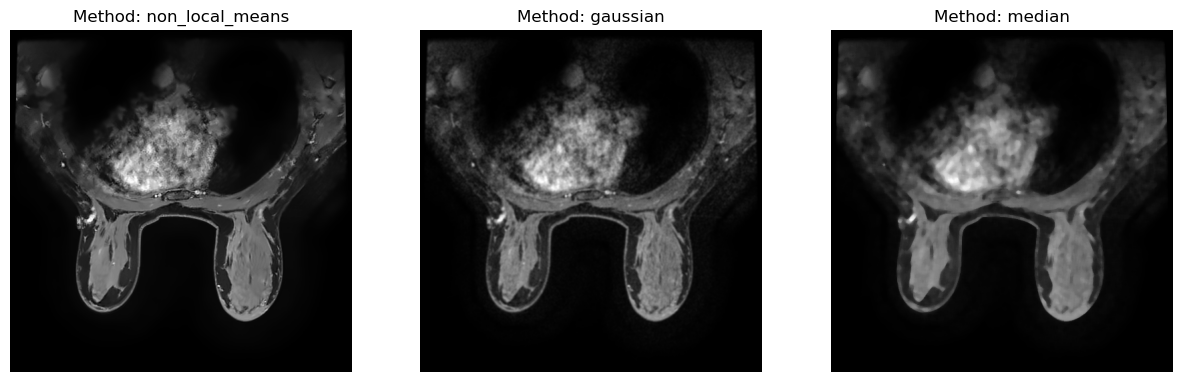

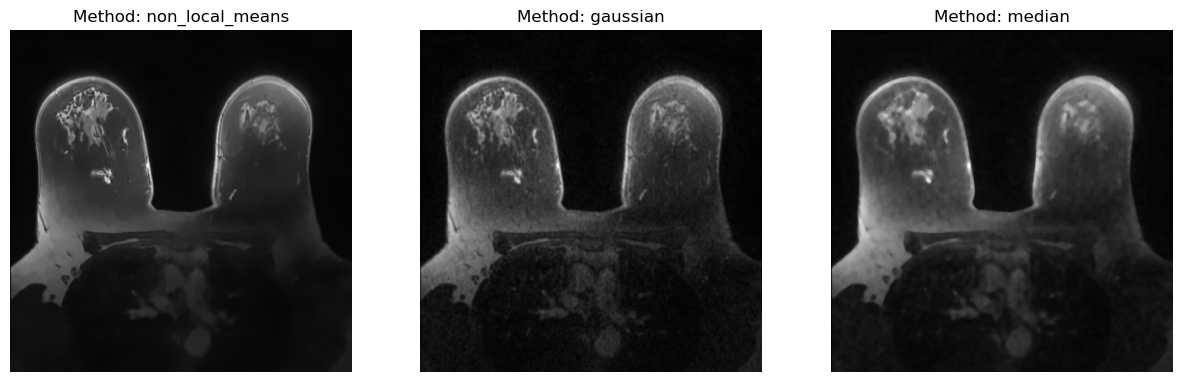

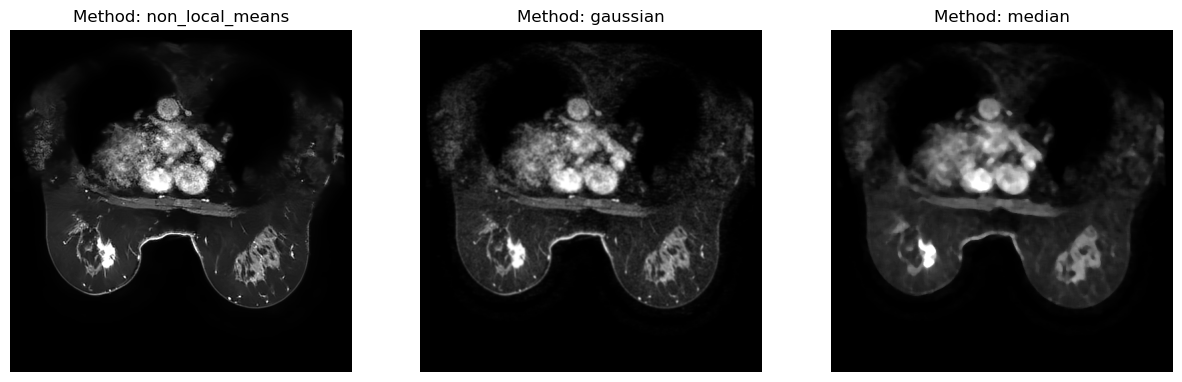

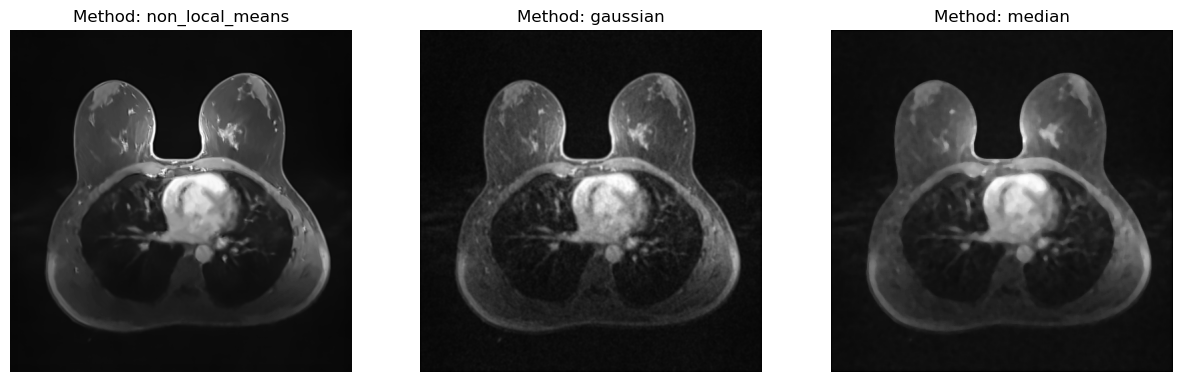

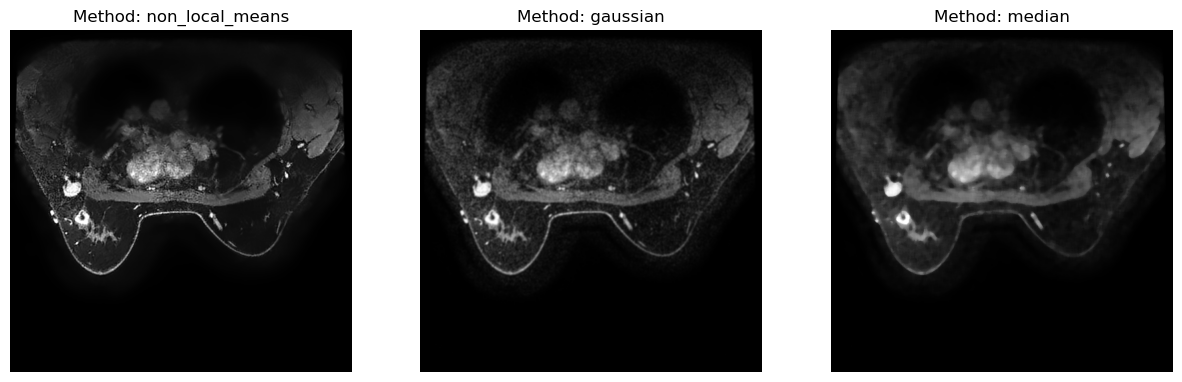

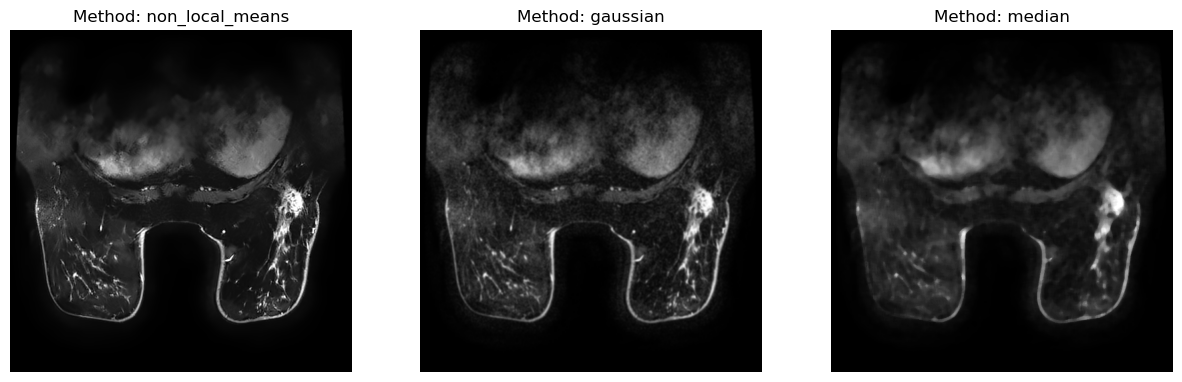

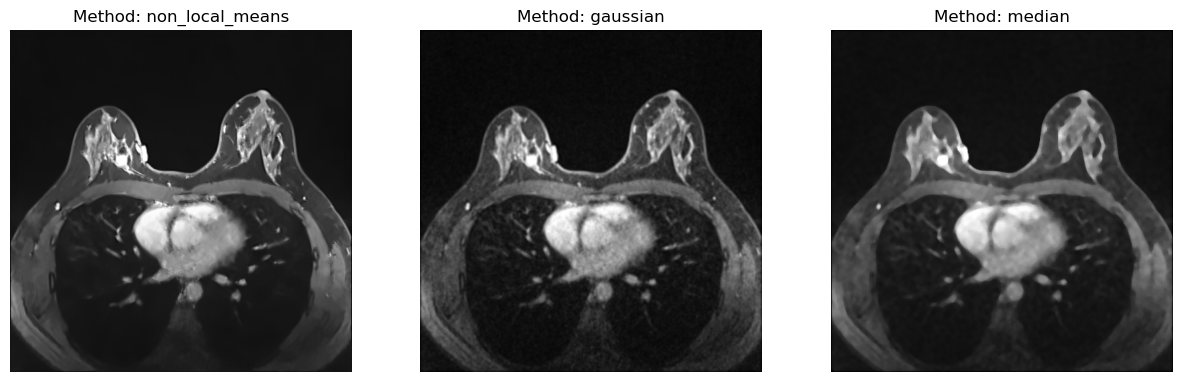

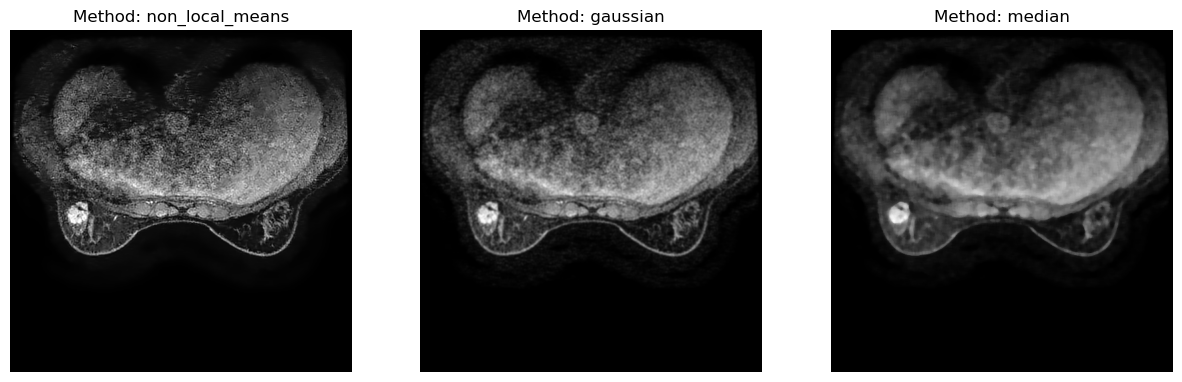

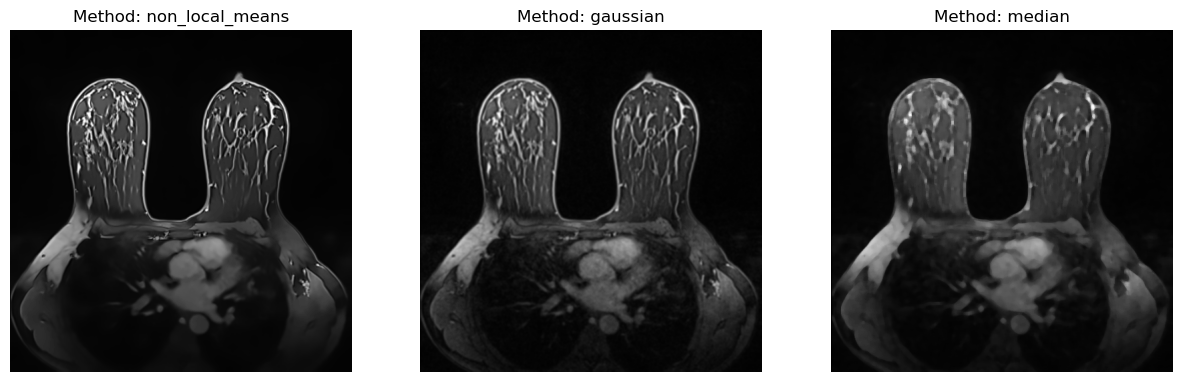

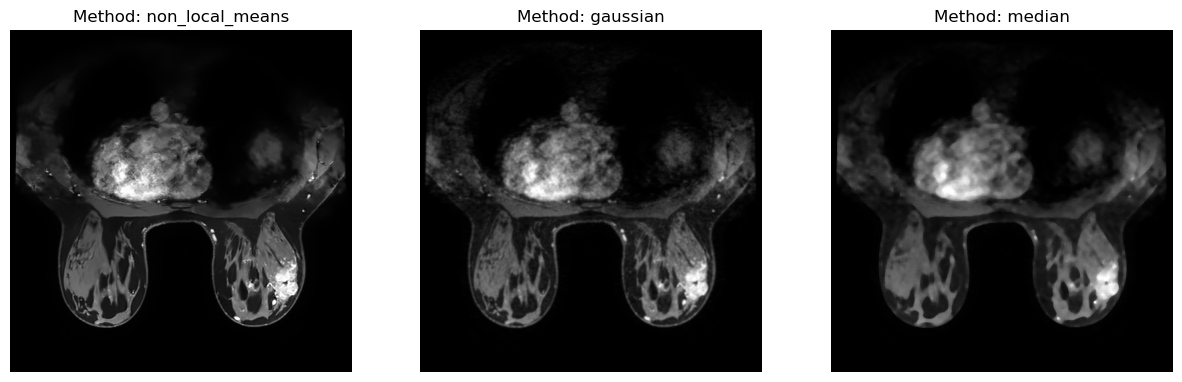

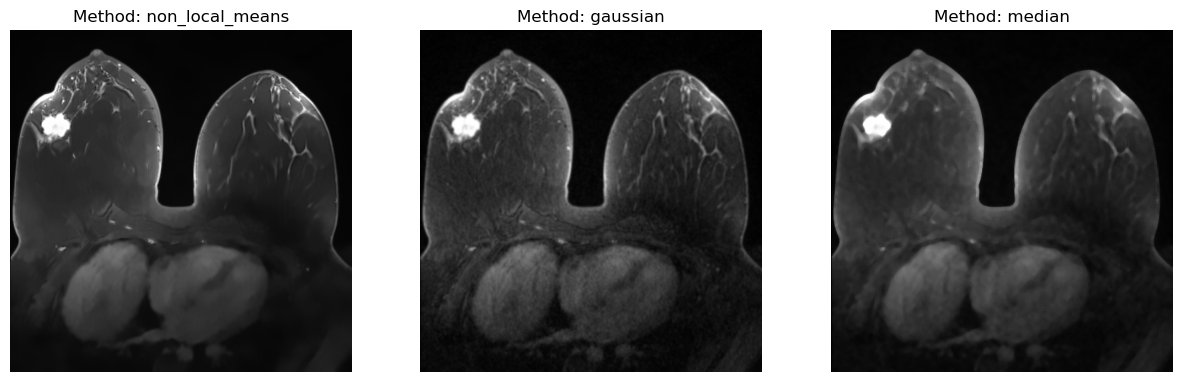

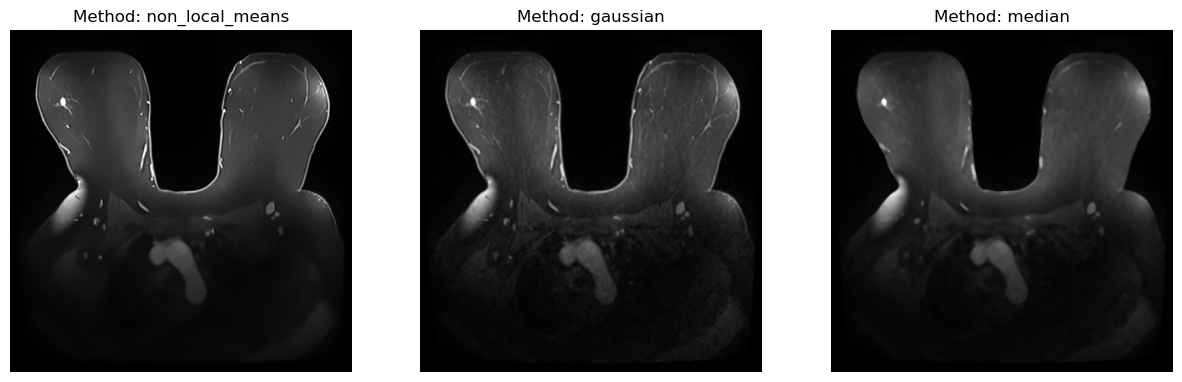

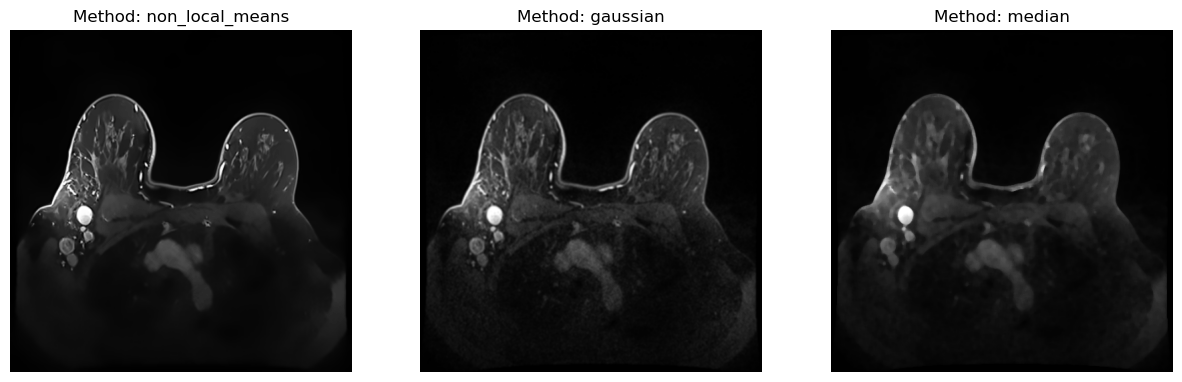

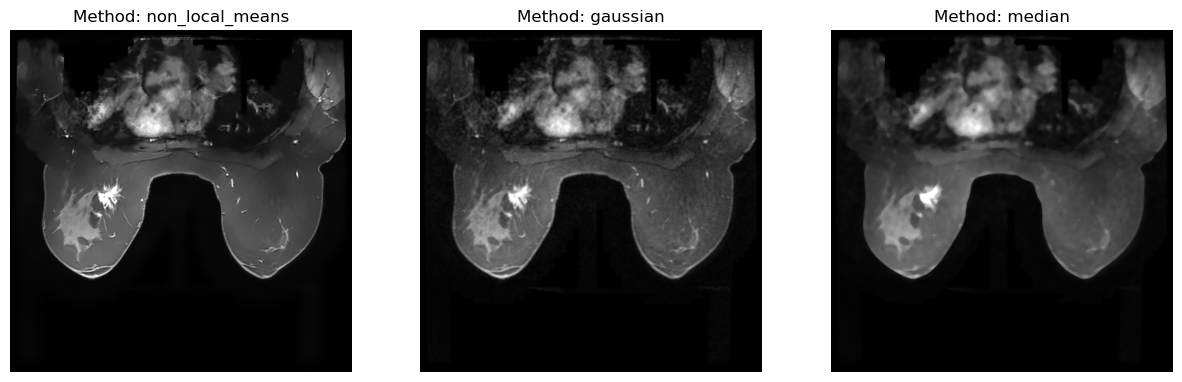

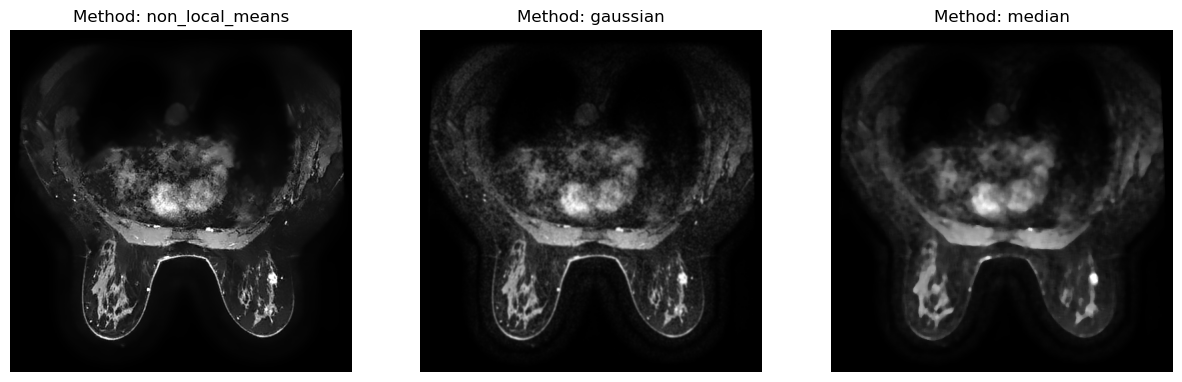

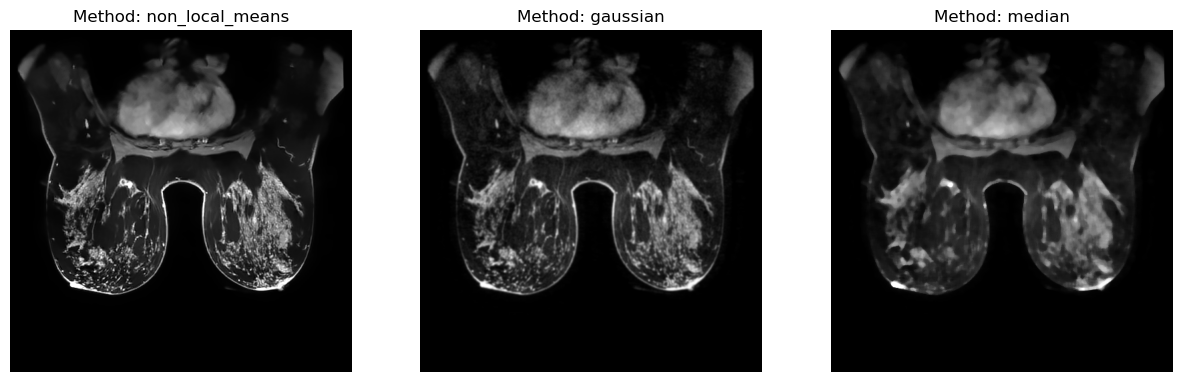

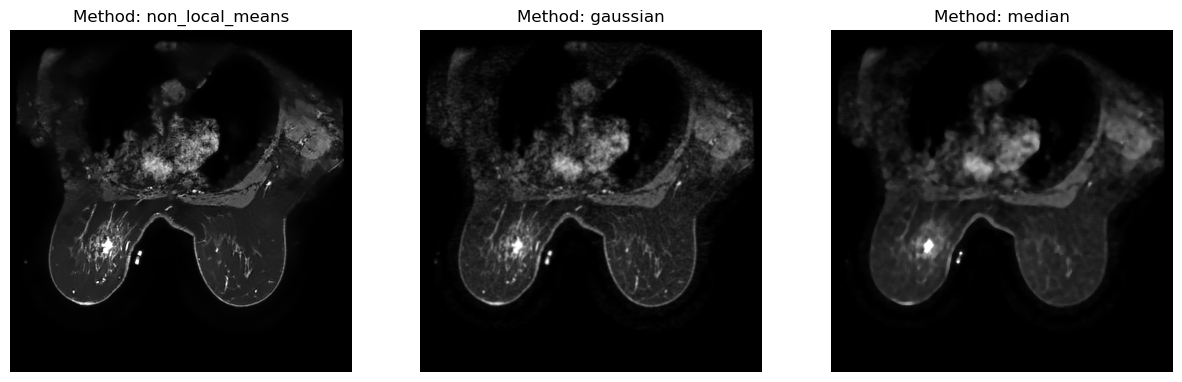

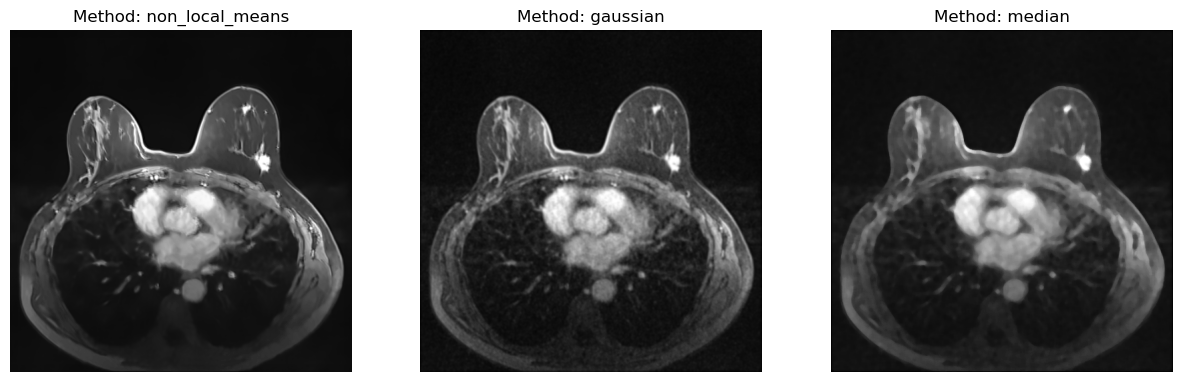

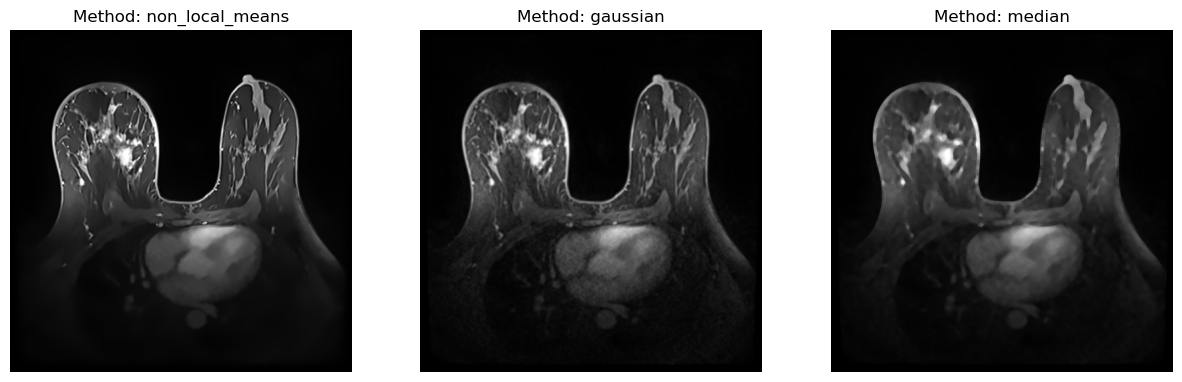

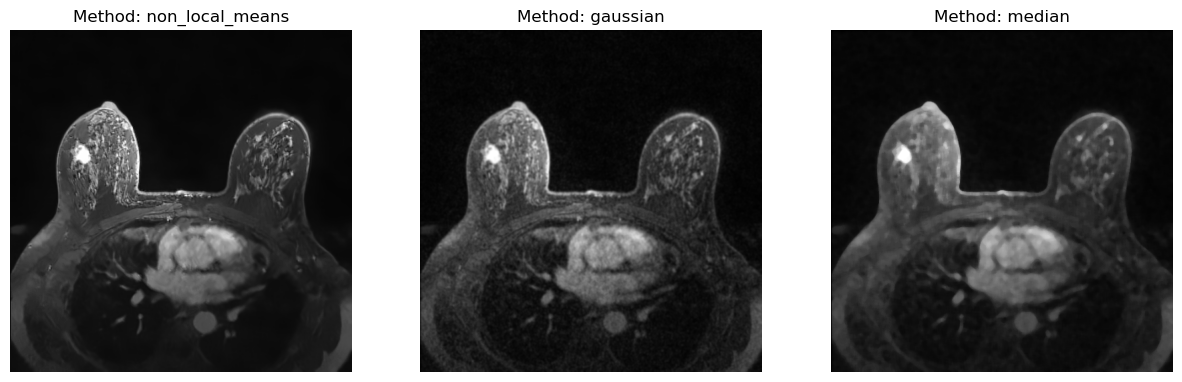

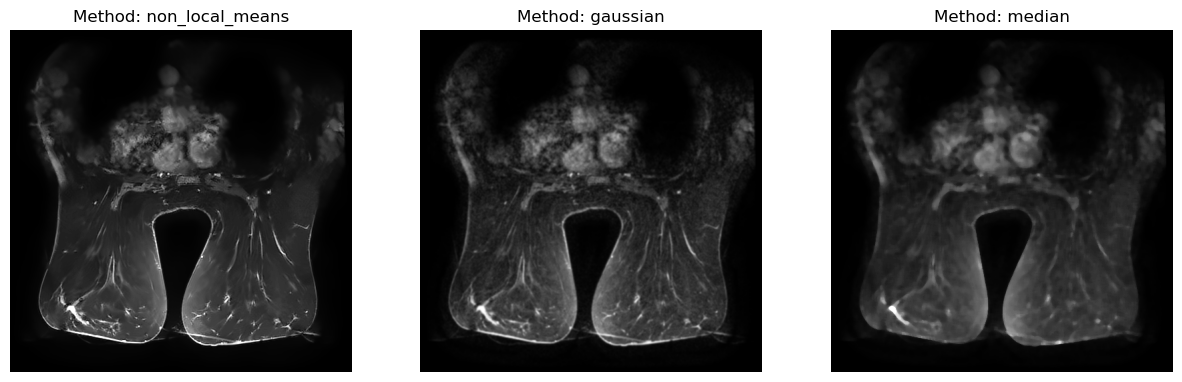

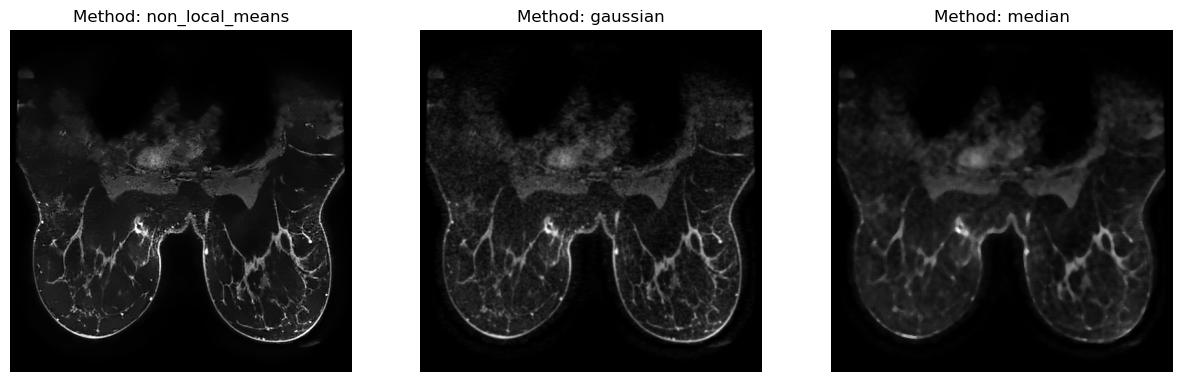

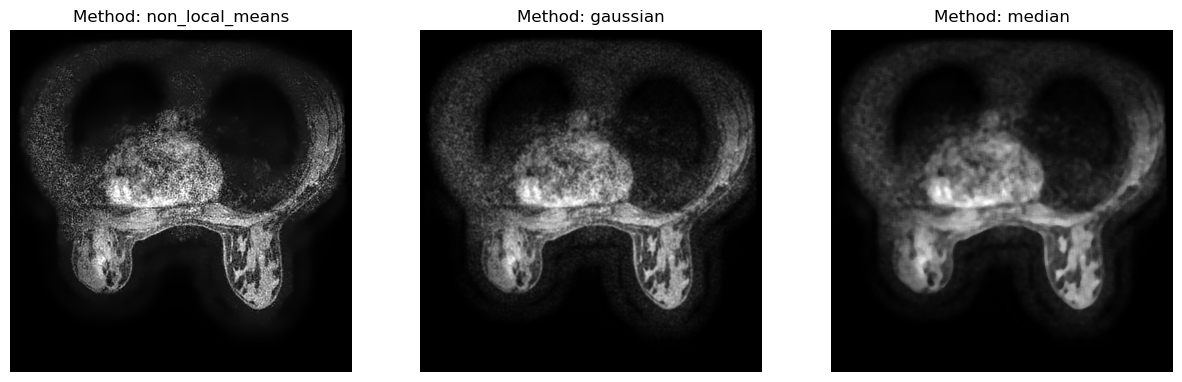

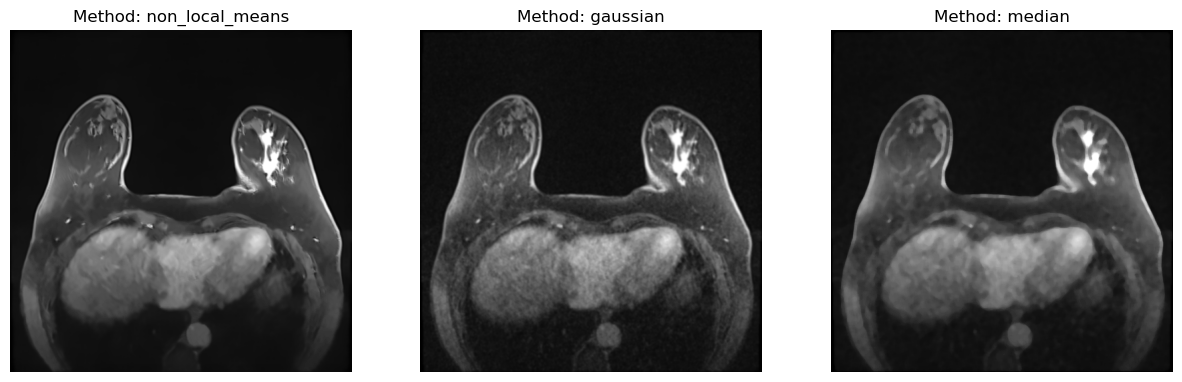

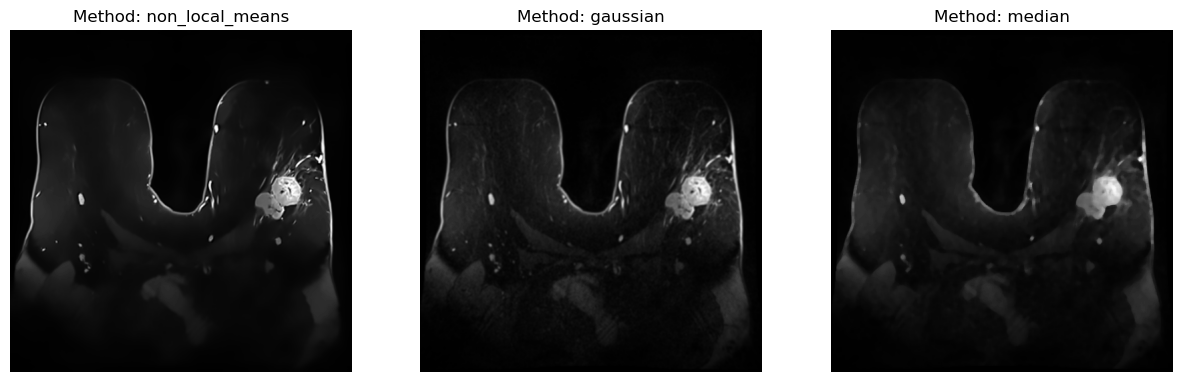

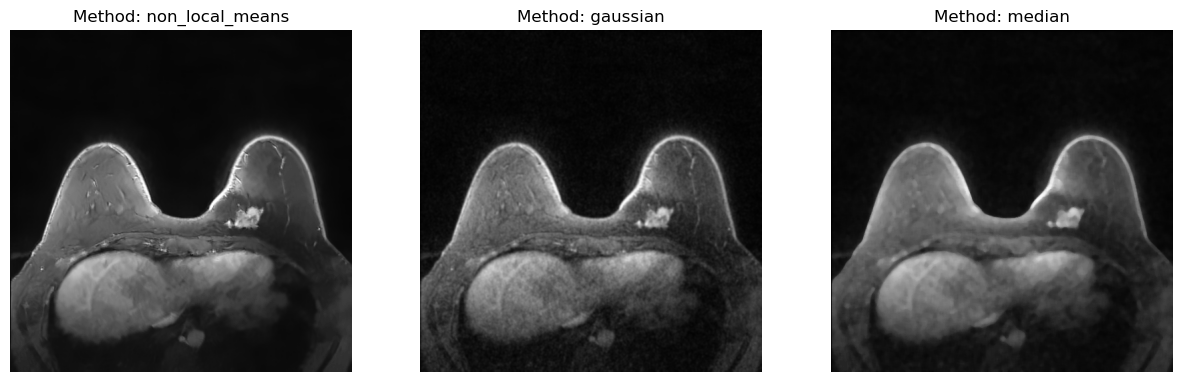

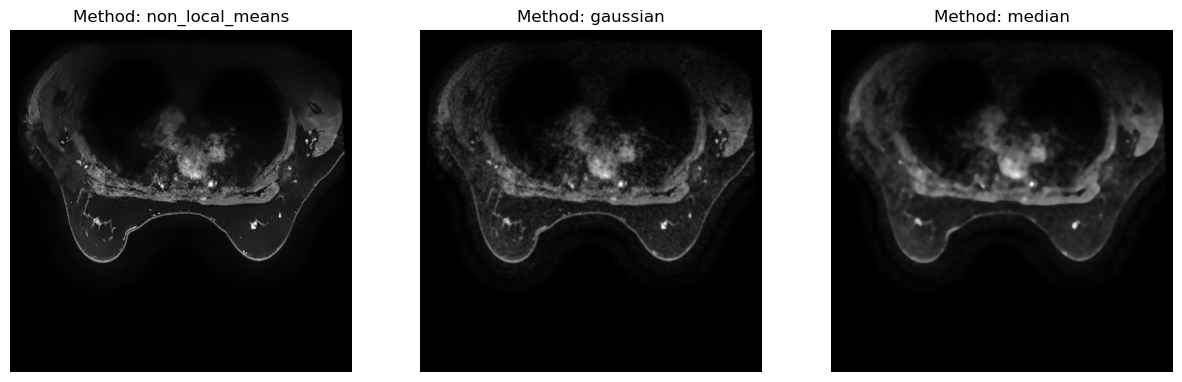

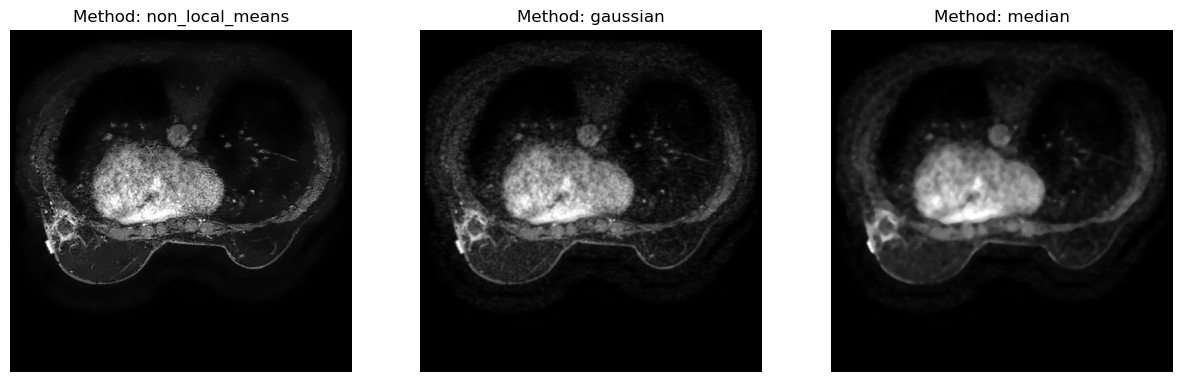

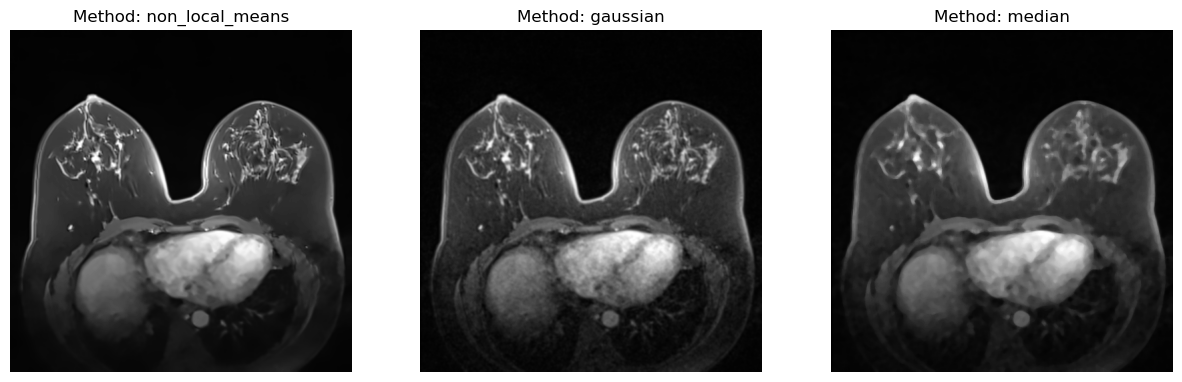

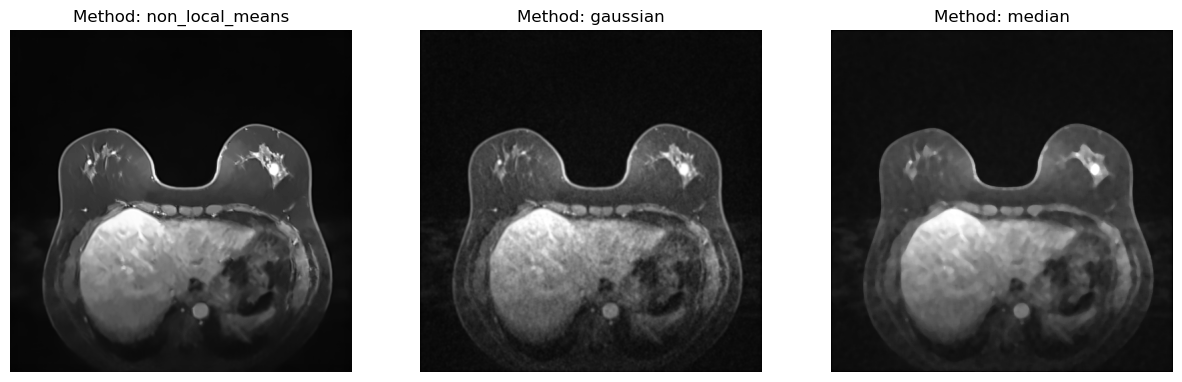

In [11]:
method_args ={
    'gaussian': {'kernel_size': (9, 9)},
    'median': {'kernel': 7}
}
all_filtered_images = filtering(images, method_args = method_args)

for i, filtered_versions in enumerate(all_filtered_images):
    display_filtered_images(filtered_versions, i)

In [ ]:
all_filtered_templates = filtering(medijastinum_, method_args = method_args)
for i, filtered_versions in enumerate(all_filtered_templates):
    display_filtered_images(filtered_versions, i)

In [15]:
#------------------------bilateralno filtriranje-------------------------------
filtered_images_org_bilateral = []
filtered_images_nlm_bilateral = []
for i in range(len(images)):
        img_org_bilateral = cv2.bilateralFilter(images[i], d=30, sigmaColor=30, sigmaSpace=30)
        filt_img = all_filtered_images[i]['non_local_means'].astype(np.uint8)
        img_filt_bilateral = cv2.bilateralFilter(filt_img, d=30, sigmaColor=30, sigmaSpace=30)
        filtered_images_org_bilateral.append(img_org_bilateral)
        filtered_images_nlm_bilateral.append(filt_img)

In [ ]:
def display_bilateral_comparison(images_org, images_org_bilateral, images_nlm_bilateral, start_index=0, end_index=None):
    if end_index is None:
        end_index = len(images_org)
    
    for i in range(start_index, end_index):
        plt.figure(figsize=(15,5))
        
        # Originalna slika
        plt.subplot(1,3,1)
        plt.imshow(images_org[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Original + bilateral
        plt.subplot(1,3,2)
        plt.imshow(images_org_bilateral[i], cmap='gray')
        plt.title("Original + Bilateral")
        plt.axis('off')
        
        # Filtrirana + bilateral
        plt.subplot(1,3,3)
        plt.imshow(images_nlm_bilateral[i], cmap='gray')
        plt.title("Non-local means + Bilateral")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

display_bilateral_comparison(images, filtered_images_org_bilateral, filtered_images_nlm_bilateral)